In [1]:
from reservoir_rls import *
from lorenz63 import *
from sklearn import preprocessing

In [2]:
res1 = reservoir(3,300,forget = 0.995, input_weight = 0.01, LM_regularization = 1e-10, delta = 1e6)
res2 = reservoir(3,300,forget = 1, input_weight = 0.01, regularization = 1e-7)

In [3]:
data_length = 100000
step = 0.05
r_t = lambda x: r_t_const(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step)

sync_length = 1000
num_tests = 100
train_length = 800
pred_length = 200

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
scaled_data = np.copy(data)
scaled_data = np.ascontiguousarray(scaled_data)

In [4]:
valid_times_RLS = cross_validation_performance(scaled_data,res1,num_tests,sync_length, \
   train_length, pred_length,train_method = 'RLS')
print(np.median(valid_times_RLS))
valid_times_norm = cross_validation_performance(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal')
print(np.median(valid_times_norm))

  2%|▏         | 2/100 [00:00<00:08, 11.89it/s]

132.5


100%|██████████| 100/100 [00:06<00:00, 15.24it/s]

140.5


In [17]:
res1 = reservoir(3,300,forget = 0.98, input_weight = 0.01, LM_regularization = 1e-5, delta = 1e4)
res2 = reservoir(3,300,forget = 1, input_weight = 0.01, regularization = 1e-7)

In [18]:
data_length = 100000
step = 0.05
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step)

sync_length = 1000
num_tests = 100
train_length = 800
pred_length = 200

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
scaled_data = np.copy(data)
scaled_data = np.ascontiguousarray(scaled_data)

  0%|          | 0/100 [00:00<?, ?it/s]

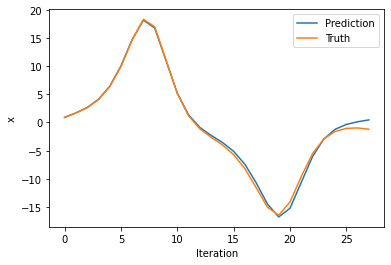

  1%|          | 1/100 [00:00<01:32,  1.07it/s]

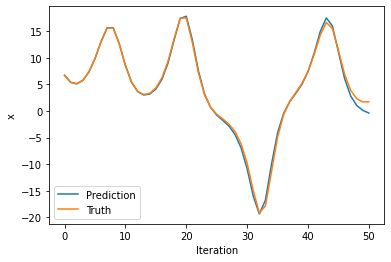

  2%|▏         | 2/100 [00:01<01:30,  1.08it/s]

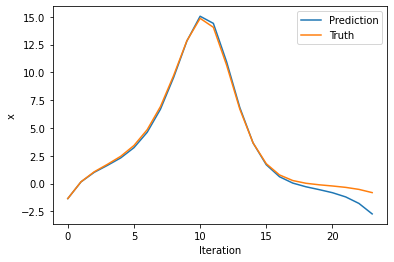

  3%|▎         | 3/100 [00:02<01:27,  1.11it/s]

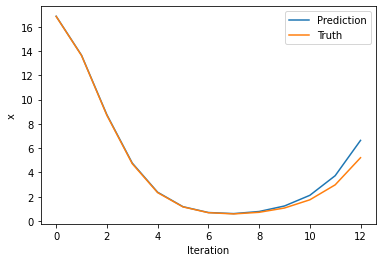

  4%|▍         | 4/100 [00:03<01:25,  1.12it/s]

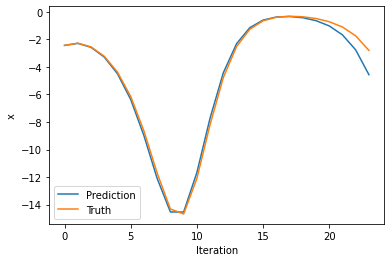

  5%|▌         | 5/100 [00:04<01:29,  1.06it/s]

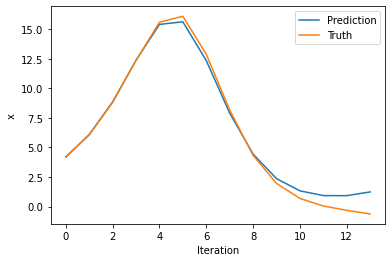

  6%|▌         | 6/100 [00:05<01:31,  1.03it/s]

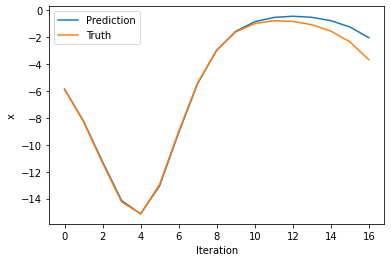

  7%|▋         | 7/100 [00:06<01:33,  1.00s/it]

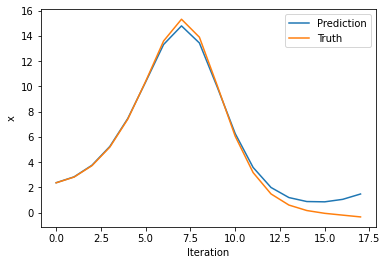

  8%|▊         | 8/100 [00:07<01:33,  1.02s/it]

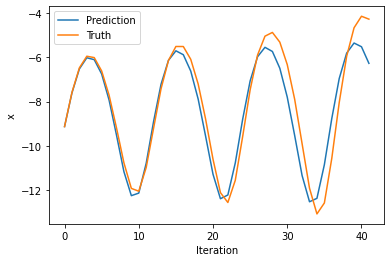

  9%|▉         | 9/100 [00:08<01:36,  1.06s/it]

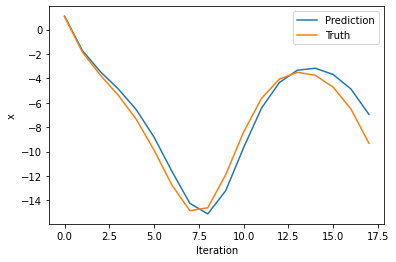

 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

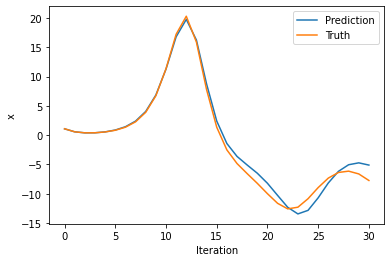

 11%|█         | 11/100 [00:11<01:40,  1.13s/it]

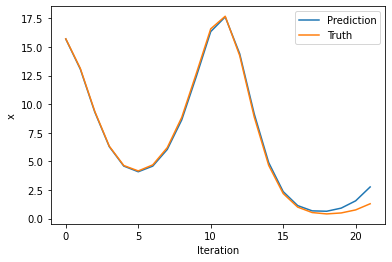

 12%|█▏        | 12/100 [00:12<01:38,  1.12s/it]

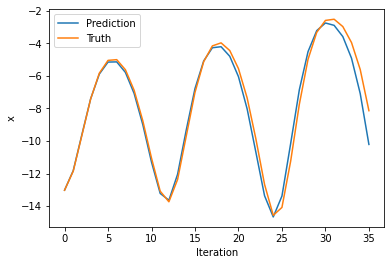

 13%|█▎        | 13/100 [00:13<01:35,  1.10s/it]

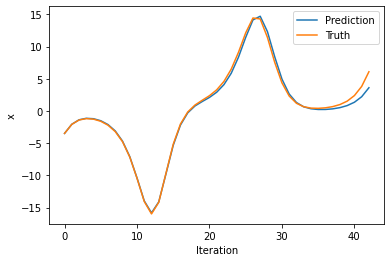

 14%|█▍        | 14/100 [00:14<01:35,  1.11s/it]

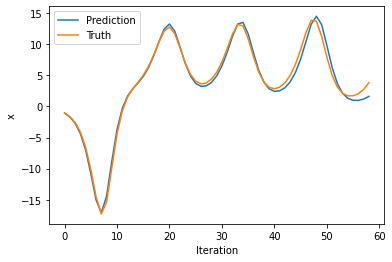

 15%|█▌        | 15/100 [00:15<01:35,  1.12s/it]

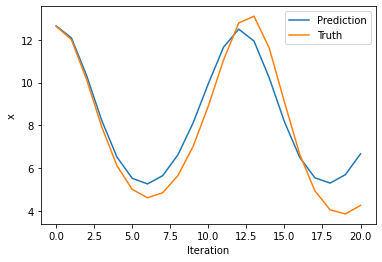

 16%|█▌        | 16/100 [00:16<01:33,  1.11s/it]

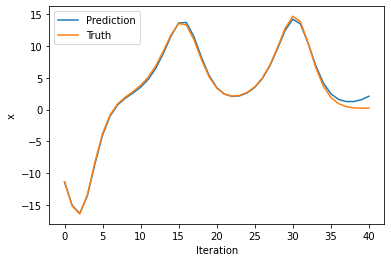

 17%|█▋        | 17/100 [00:18<01:34,  1.14s/it]

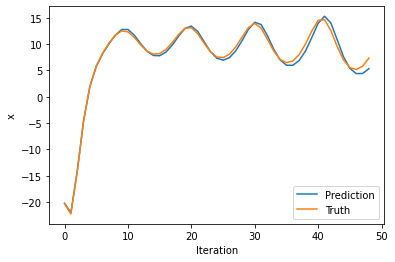

 18%|█▊        | 18/100 [00:19<01:33,  1.14s/it]

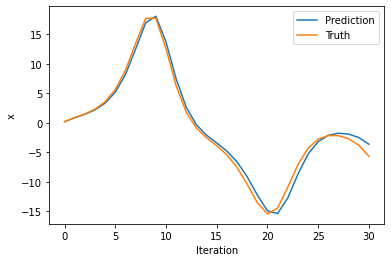

 19%|█▉        | 19/100 [00:20<01:34,  1.17s/it]

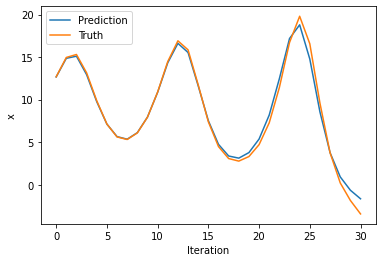

 20%|██        | 20/100 [00:21<01:31,  1.15s/it]

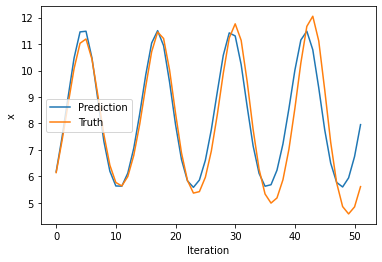

 21%|██        | 21/100 [00:22<01:33,  1.18s/it]

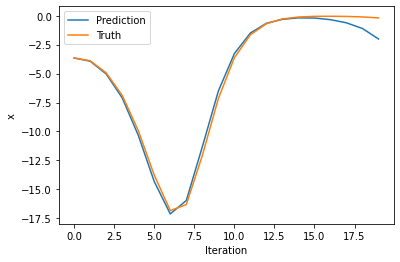

 22%|██▏       | 22/100 [00:23<01:30,  1.17s/it]

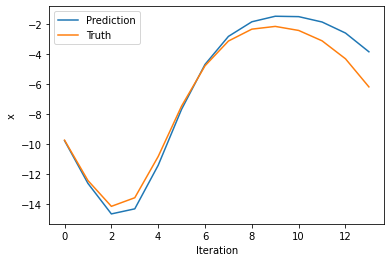

 23%|██▎       | 23/100 [00:25<01:30,  1.18s/it]

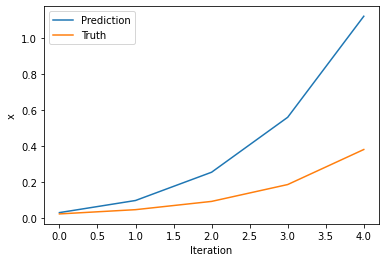

 24%|██▍       | 24/100 [00:26<01:28,  1.17s/it]

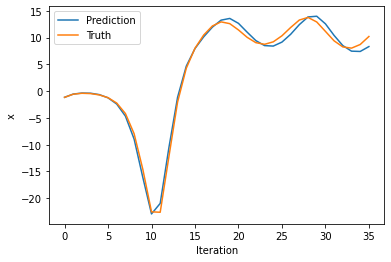

 25%|██▌       | 25/100 [00:27<01:26,  1.15s/it]

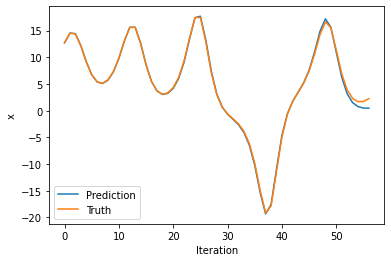

 26%|██▌       | 26/100 [00:28<01:22,  1.11s/it]


KeyboardInterrupt: 

In [19]:
valid_times_RLS = cross_validation_performance(scaled_data,res1,num_tests,sync_length, \
   train_length, pred_length,train_method = 'RLS')
print(np.median(valid_times_RLS))
valid_times_norm = cross_validation_performance(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal')
print(np.median(valid_times_norm))

In [8]:
x = np.random.rand(3,3)
np.append(x,x,axis = 1).shape

(3, 6)

In [9]:
step = 0.05
np.arange(-10*step,step,step)

array([-5.00000000e-01, -4.50000000e-01, -4.00000000e-01, -3.50000000e-01,
       -3.00000000e-01, -2.50000000e-01, -2.00000000e-01, -1.50000000e-01,
       -1.00000000e-01, -5.00000000e-02, -1.11022302e-16])